In [9]:
import h5py
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw, PIL.ImageChops, PIL.ImageOps
import os
import random
import string
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

%matplotlib inline

### List of characters

In [2]:
chars = string.ascii_letters + string.digits + string.punctuation
print(chars)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


### Gets fonts

In [3]:
def get_ttfs(d='/TTF'):
    print(d)
    for dirpath, dirname, filenames in os.walk(d):
        for filename in filenames:
            if filename.endswith('.ttf') or filename.endswith('.TTF'):
                yield os.path.join(dirpath, filename)

In [4]:
w_out, h_out = 64, 64
w, h = 256,256#64, 64
# w0, h0 = 64, 64 #128, 128

In [5]:
def read_font(fn):
    # loads a font object
    font = PIL.ImageFont.truetype(fn, 60)#175)

    # Used to scale the image
    min_top = float('inf')
    max_bottom = float('-inf')
    min_left = float('inf')
    max_right = float('-inf')
    max_width = 0
    imgs = []
    data = []
    
    # Loops for each character  to extract the bounding box
    for char in chars:
        # Create image of character
        img = PIL.Image.new("L", (w, h), 255) # "L" = 8bit pixels B+W, 255 is for white background
        draw = PIL.ImageDraw.Draw(img)
        draw.text((int(w/2), int(h/2)), char, font=font)
        
        # Extract the bounding box, this needs to happen on the inverted color image
        inv_img = PIL.ImageOps.invert(img)
        left, top, right, bottom = inv_img.getbbox()
                
        min_top = min(min_top, top)
        max_bottom = max(max_bottom, bottom)
        min_left = min(min_left, left)
        max_right = max(max_right, right)
        max_width = max(max_width, right - left)
        imgs.append((left, right, img))
            
    scale = min(w_out/(max_width),h_out/(max_bottom-min_top))

    # Crop each image and rescale
    for left, right, img in imgs:
        img = img.crop((left,min_top,right,max_bottom))
        
        # Rescale the image
        new_w = (right - left)*scale
        new_h = (max_bottom - min_top)*scale
        img = img.resize((int(new_w), int(new_h)), PIL.Image.ANTIALIAS)
        
        # Fit into a square of size w_out,h_out
        new_img = PIL.Image.new('L',(w_out,h_out),255)
        x_offset = int((w_out - new_w)/2)
        y_offset = int((h_out - new_h)/2)
        new_img.paste(img,(x_offset,y_offset))
        matrix = np.array(new_img.getdata()).reshape((h_out, w_out))
        data.append(matrix)

    plt.figure(figsize=[15,10])
    for i in range(len(data)):
        plt.subplot(10,10,i+1)
        plt.imshow(data[i],cmap='gray',interpolation='lanczos')
#         plt.axis('off')

    return np.array(data)

### Gets the data

In [6]:
f = h5py.File('fonts.hdf5', 'w')
dset = f.create_dataset('fonts', (1, len(chars), h_out, w_out), chunks=(1, len(chars), h_out, w_out), 
                        maxshape=(None, len(chars), h_out, w_out), dtype='u1')

/Users/robertomac/ds/metis/robreifgh/Repos/blogs/2018/Fonts/TTF
0 DejaVuSerif
(94, 64, 64)
1 VIVALDII
(94, 64, 64)


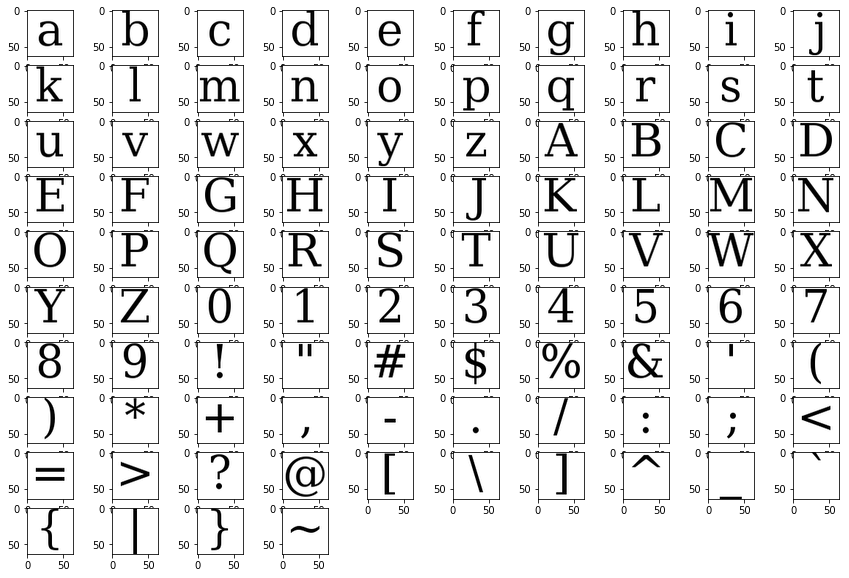

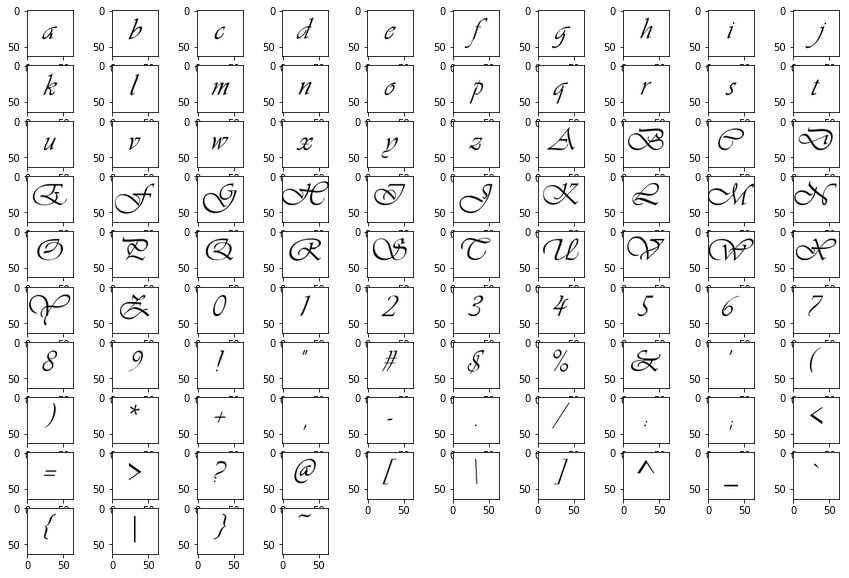

In [7]:
i = 0
TTF_FileName = []
for fn in get_ttfs(d='/Users/robertomac/ds/metis/robreifgh/Repos/blogs/2018/Fonts/TTF'):

    print (i,fn.split('/')[-1].split('.')[0])
    TTF_FileName.append(fn.split('/')[-1].split('.')[0])

    try:
        data = read_font(fn)
    except: # IOError:
        print ('was not able to read', fn)
        continue

    print (data.shape)
    dset.resize((i+1, len(chars), h_out, w_out))
    dset[i] = data
    i += 1
    f.flush()
#    if i == 4:
#        break

In [8]:
f.close()

In [10]:
pd.DataFrame(TTF_FileName).to_csv('TTF_Filenames.csv')